In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

USER_HISTORY_PATH = "../data/raw/user_history.csv"
NOTIF_PATH = "../data/raw/notification_allowed.csv"

user_history = pd.read_csv(USER_HISTORY_PATH)
notif = pd.read_csv(NOTIF_PATH)

In [3]:
user_base = pd.read_csv("../data/processed/user_base.csv")

In [4]:
dau_by_day = ( # broj aktivnih igraca tog dana
    user_history[user_history["dau"] == 1]
    .groupby("date_id")["login_id"]
    .nunique()
)

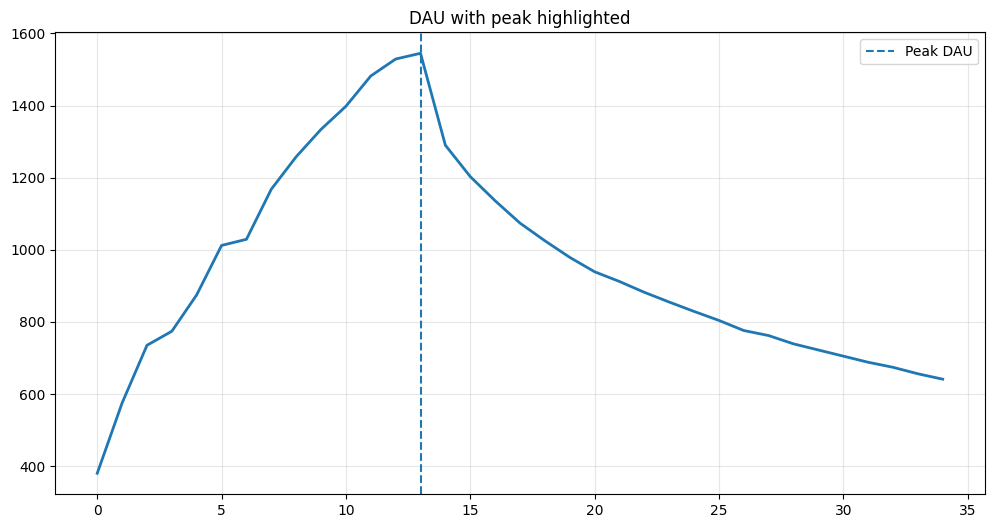

In [5]:
plt.figure(figsize=(12,6))
plt.plot(dau_by_day, linewidth=2)

plt.axvline(dau_by_day.idxmax(), linestyle="--", label="Peak DAU")
plt.legend()

plt.title("DAU with peak highlighted")
plt.grid(alpha=0.3)
plt.show()

***DAU raste jer novi korisnici svakog dana
ulaze u eksperiment, dostize vrhunac kada se registracija zavrsi (14 dan),
a zatim postepeno opada zbog prirodnog odliva korisnika,
formirajuci retention krivu kohorte.***

```Akvizicija```
- sticanje novih korisnika

```Churn```
- odlazak korisnika(prestanu da koriste app, otkazu pretplatu..)

```Cohort``` 
- grupa korisnika koji su poceli u isto vreme ili pod istim uslovima
- reg_date_id(0) i reg_date_id(1) su 2 cohorte

## User Activity Relative to Registration Day


In [6]:
user_history["days_since_registration"] = (
    user_history["date_id"] - user_history["registration_date_id"]
)

retention_curve = (
    user_history[user_history["dau"] == 1]
    .groupby("days_since_registration")["login_id"]
    .nunique()
)

retention_curve_percent = retention_curve / retention_curve.iloc[0] * 100

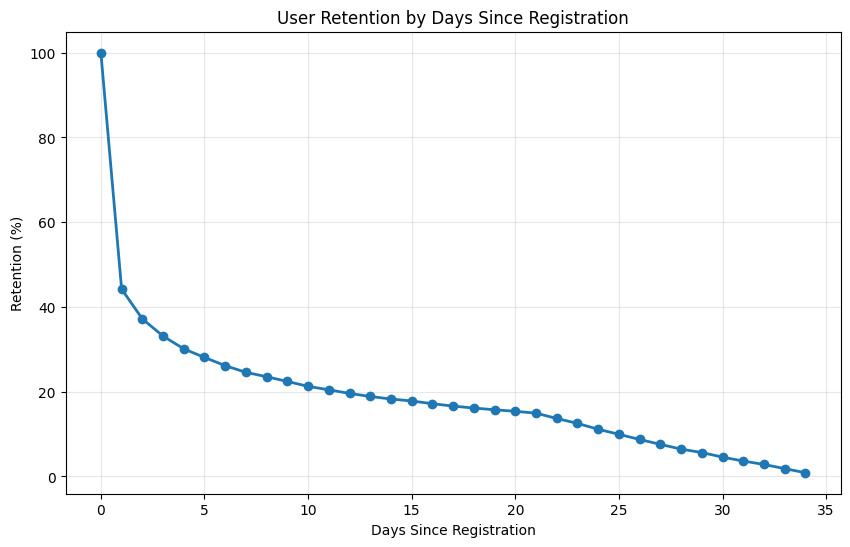

In [7]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,6))

plt.plot(
    retention_curve_percent,
    marker="o",
    linewidth=2
)

plt.title("User Retention by Days Since Registration")
plt.xlabel("Days Since Registration")
plt.ylabel("Retention (%)")

plt.grid(alpha=0.3)
plt.show()


```Retention curve```
- pokazuje kako umiru cohort-e
- Vidimo da je ogroman drop na danu 1
    - vratilo se samo 44% da igra sledeci dan
    - ***smatram da je to normalno u igrama***
- 3/4 ljudi ode u prvoj nedelji
- *Day 14* < 20%

**ZAKLJUCAK**
- Posto vecina **churna** se desi VEOMA RANO
    - sve sto utice na Day 1 experience je ***jako kriticno***
    - zato se i vidi mali D1 retention za rani popup

## Retention curve by experiment group

In [8]:
# uh = user_history

In [9]:
uh_with_group = user_history.merge(
    user_base[["login_id", "group"]],
    on = "login_id",
    how = "left"
)

In [10]:
active = uh_with_group[uh_with_group["dau"] == 1]

retention_by_group = (
    active
    .groupby(["group", "days_since_registration"])["login_id"]
    .nunique()
    .reset_index()
)

retention_by_group["retention_percent"] = retention_by_group.groupby("group")["login_id"] \
    .transform(lambda x: x / x.iloc[0] * 100)

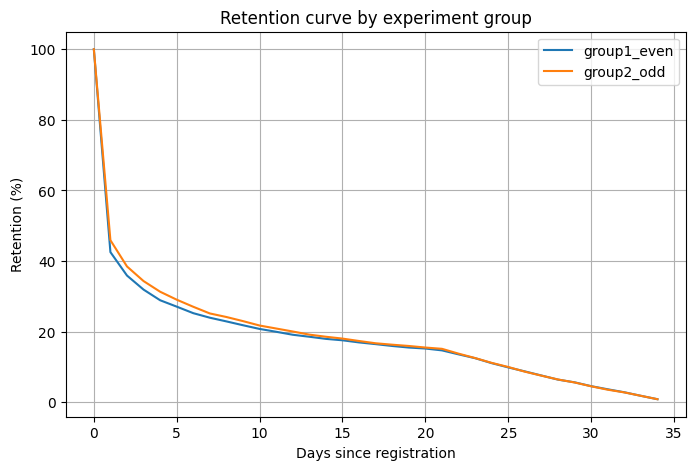

In [11]:
plt.figure(figsize=(8,5))

for g in retention_by_group["group"].unique():
    sub = retention_by_group[retention_by_group["group"] == g]
    plt.plot(sub["days_since_registration"], sub["retention_percent"], label=g)

plt.xlabel("Days since registration")
plt.ylabel("Retention (%)")
plt.title("Retention curve by experiment group")
plt.legend()
plt.grid(True)
plt.show()

***Vidimo da nema long time stete***

## Retention curve by exposed users

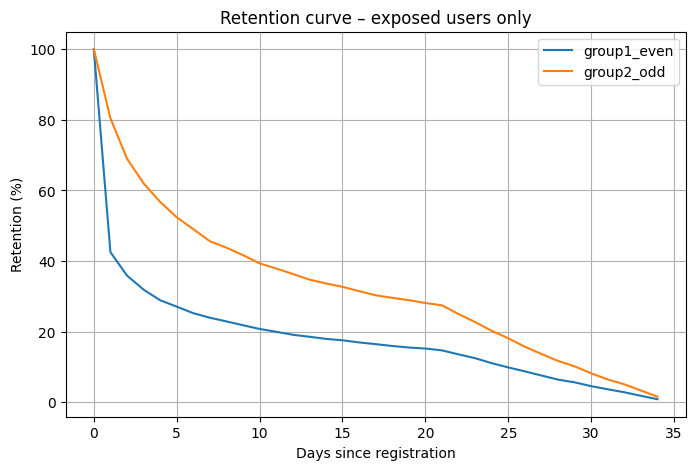

In [12]:
exposed_users = user_base[user_base["notif_exposed"] == True][["login_id", "group"]]

uh_exposed = user_history.merge(
    exposed_users,
    on="login_id",
    how="inner"
)

retention_exposed = (
    uh_exposed[uh_exposed["dau"] == 1]
    .groupby(["group", "days_since_registration"])["login_id"]
    .nunique()
    .reset_index()
)


base_exposed = (
    exposed_users
    .groupby("group")["login_id"]
    .nunique()
    .reset_index(name="base_users")
)

retention_exposed = retention_exposed.merge(base_exposed, on="group")

retention_exposed["retention_percent"] = (
    retention_exposed["login_id"] / retention_exposed["base_users"] * 100
)


plt.figure(figsize=(8,5))

for g in retention_exposed["group"].unique():
    sub = retention_exposed[retention_exposed["group"] == g]
    plt.plot(
        sub["days_since_registration"],
        sub["retention_percent"],
        label=g
    )

plt.xlabel("Days since registration")
plt.ylabel("Retention (%)")
plt.title("Retention curve – exposed users only")
plt.legend()
plt.grid(True)
plt.show()

***Vidimo da medju `exposed userima` grupa 2 ima duplo veci retention, ali opet, zakljucili smo da to dovodi do `selection biasa`***

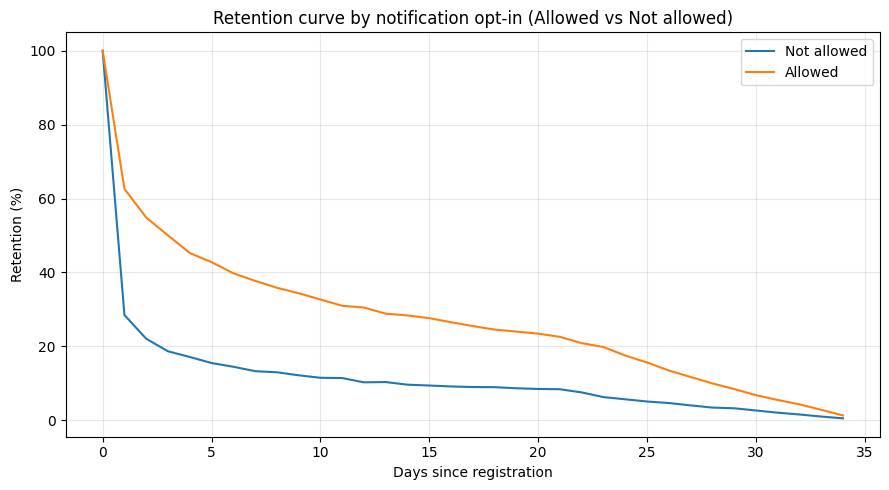

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

uh_allow = user_history.merge(
    user_base[["login_id", "allowed"]],
    on="login_id",
    how="left"
)

uh_allow["allowed"] = uh_allow["allowed"].fillna(0).astype(int)

uh_allow["days_since_registration"] = uh_allow["date_id"] - uh_allow["registration_date_id"]

active = uh_allow[uh_allow["dau"] == 1].copy()

ret_counts = (
    active
    .groupby(["allowed", "days_since_registration"])["login_id"]
    .nunique()
    .reset_index(name="active_users")
)

base = ret_counts[ret_counts["days_since_registration"] == 0][["allowed", "active_users"]].rename(
    columns={"active_users": "day0_users"}
)

ret = ret_counts.merge(base, on="allowed", how="left")
ret["retention_percent"] = ret["active_users"] / ret["day0_users"] * 100

plt.figure(figsize=(9,5))

label_map = {0: "Not allowed", 1: "Allowed"}

for a in sorted(ret["allowed"].unique()):
    sub = ret[ret["allowed"] == a].sort_values("days_since_registration")
    plt.plot(sub["days_since_registration"], sub["retention_percent"], label=label_map.get(a, str(a)))

plt.xlabel("Days since registration")
plt.ylabel("Retention (%)")
plt.title("Retention curve by notification opt-in (Allowed vs Not allowed)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

***Korisnici koji prihvate notifikacije imaju veci retention***

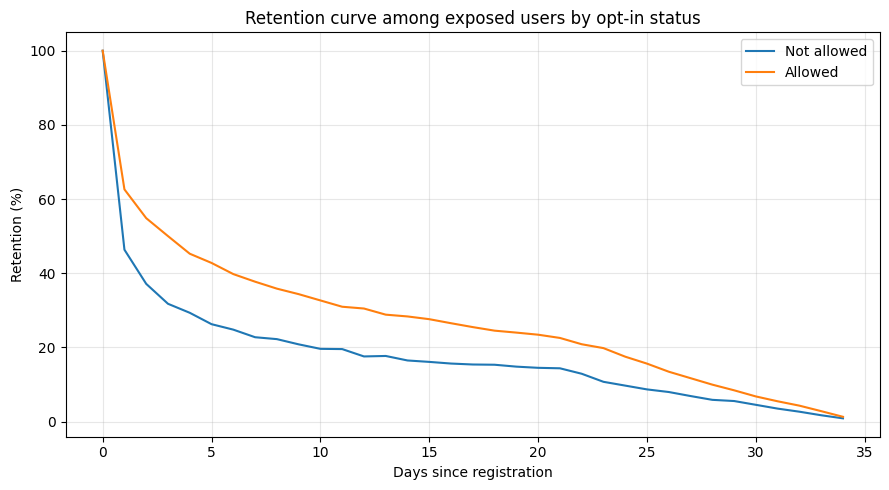

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

exposed_allow = user_base[user_base["notif_exposed"] == True][
    ["login_id", "allowed"]
]

uh_exp_allow = user_history.merge(
    exposed_allow,
    on="login_id",
    how="inner"
)

uh_exp_allow["days_since_registration"] = (
    uh_exp_allow["date_id"] - uh_exp_allow["registration_date_id"]
)

active = uh_exp_allow[uh_exp_allow["dau"] == 1].copy()

ret_counts = (
    active
    .groupby(["allowed", "days_since_registration"])["login_id"]
    .nunique()
    .reset_index(name="active_users")
)

base = (
    ret_counts[ret_counts["days_since_registration"] == 0]
    .rename(columns={"active_users": "day0_users"})[["allowed", "day0_users"]]
)

ret = ret_counts.merge(base, on="allowed", how="left")
ret["retention_percent"] = ret["active_users"] / ret["day0_users"] * 100

plt.figure(figsize=(9,5))

label_map = {0: "Not allowed", 1: "Allowed"}

for a in sorted(ret["allowed"].unique()):
    sub = ret[ret["allowed"] == a].sort_values("days_since_registration")
    plt.plot(
        sub["days_since_registration"],
        sub["retention_percent"],
        label=label_map[a]
    )

plt.xlabel("Days since registration")
plt.ylabel("Retention (%)")
plt.title("Retention curve among exposed users by opt-in status")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Early Engagement

### Playtime on first day

In [12]:
playtime = user_base[["allowed", "playtime"]]

allow_pt = playtime[playtime["allowed"] == 1]["playtime"]
noallow_pt = playtime[playtime["allowed"] == 0]["playtime"]

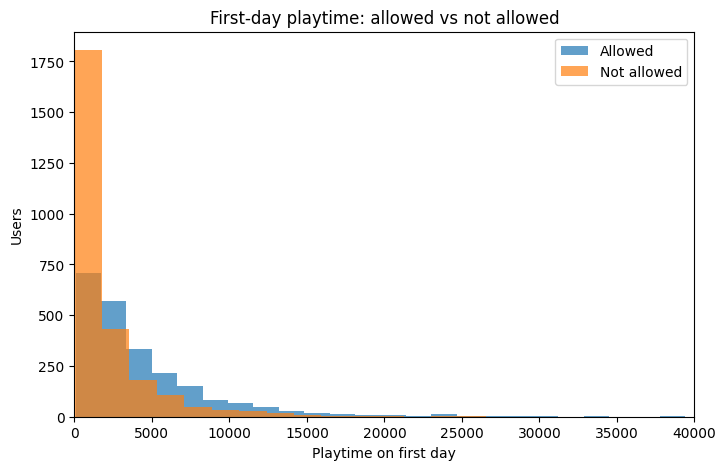

Mean playtime allowed: 4474.605664488017
Mean playtime not allowed: 2261.5219821162445
Median playtime allowed: 2915.0
Median playtime not allowed: 1130.5


In [13]:
plt.figure(figsize=(8,5))

plt.hist(allow_pt, bins=40, alpha=0.7, label="Allowed")
plt.hist(noallow_pt, bins=40, alpha=0.7, label="Not allowed")
plt.xlabel("Playtime on first day")
plt.ylabel("Users")
plt.title("First-day playtime: allowed vs not allowed")
plt.legend()
plt.xlim(0, 40000)
plt.show()

print("Mean playtime allowed:", allow_pt.mean())
print("Mean playtime not allowed:", noallow_pt.mean())
print("Median playtime allowed:", allow_pt.median())
print("Median playtime not allowed:", noallow_pt.median())

***Oko 1750 korisnika u grupi koji nisu dali dozvolu imaju prakticno 0 sekundi playtime-a***
- znaci da nisu ni igrali, a nisu ni dali dozvolu, vrv su se registrovali i odmah napustili app kad je krenuo tutorijal

| Grupa       | Mean   | Median |
| ----------- | ------ | ------ |
| Allowed     | 4474 s | 2915 s |
| Not Allowed | 2261 s | 1130 s |

- Vidimo da su Mean i Median sduplo vece za Allowed
- ***Useri koji dozvole notifikacije provode 2x vise vremena u igri vec prvog dana***
- **Distribucija**
    - Oba su right-skewed, ali allowed ima mnogo tezi rep, tj vise hardcore igraca

- **Playtime** je top predictor za allow

In [27]:
from scipy.stats import ttest_ind

tstat, pval = ttest_ind(allow_pt, noallow_pt, equal_var=False)
print("t-stat:", tstat)
print("p-value:", pval)

t-stat: 17.813636784979217
p-value: 2.44292596138837e-68


In [28]:
# p-value < 0.05, znaci da je razlika u playtime izmedu allowed i not allowed
# statisticki znacajna!

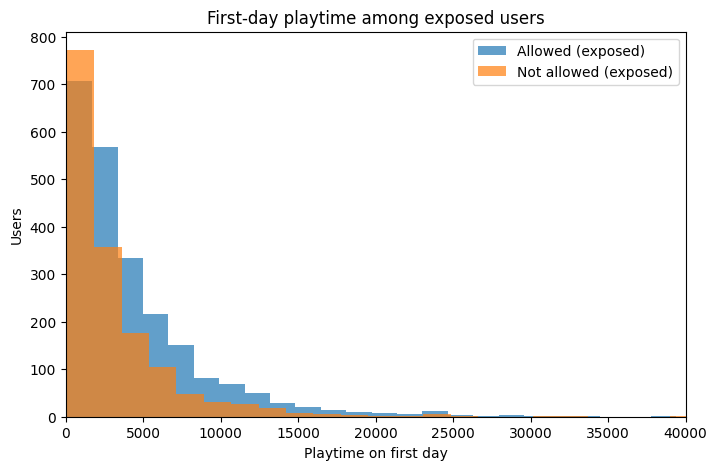

Mean playtime allowed (exposed): 4474.605664488017
Mean playtime not allowed (exposed): 3225.163043478261
Median playtime allowed (exposed): 2915.0
Median playtime not allowed (exposed): 1867.0


In [25]:
exposed = user_base[user_base["notif_exposed"] == True]

allow_pt_exp = exposed[exposed["allowed"] == 1]["playtime"]
noallow_pt_exp = exposed[exposed["allowed"] == 0]["playtime"]

plt.figure(figsize=(8,5))

plt.hist(allow_pt_exp, bins=40, alpha=0.7, label="Allowed (exposed)")
plt.hist(noallow_pt_exp, bins=40, alpha=0.7, label="Not allowed (exposed)")
plt.xlabel("Playtime on first day")
plt.ylabel("Users")
plt.title("First-day playtime among exposed users")
plt.legend()
plt.xlim(0, 40000)
plt.show()

print("Mean playtime allowed (exposed):", allow_pt_exp.mean())
print("Mean playtime not allowed (exposed):", noallow_pt_exp.mean())
print("Median playtime allowed (exposed):", allow_pt_exp.median())
print("Median playtime not allowed (exposed):", noallow_pt_exp.median())

In [29]:
tstat, pval = ttest_ind(allow_pt_exp, noallow_pt_exp, equal_var=False)
print("t-stat:", tstat)
print("p-value:", pval)

t-stat: 8.337651934225692
p-value: 1.0565289596698434e-16


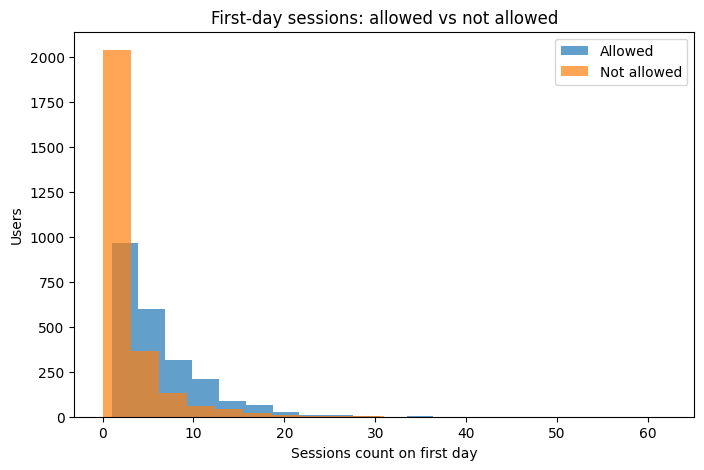

Mean sessions allowed: 5.7328976034858385
Mean sessions not allowed: 3.048435171385991
Median sessions allowed: 4.0
Median sessions not allowed: 2.0


In [30]:
sessions = user_base[["allowed", "sessions_count"]]

allow_s = sessions[sessions["allowed"] == 1]["sessions_count"]
noallow_s = sessions[sessions["allowed"] == 0]["sessions_count"]

plt.figure(figsize=(8,5))
plt.hist(allow_s, bins=20, alpha=0.7, label="Allowed")
plt.hist(noallow_s, bins=20, alpha=0.7, label="Not allowed")
plt.xlabel("Sessions count on first day")
plt.ylabel("Users")
plt.title("First-day sessions: allowed vs not allowed")
plt.legend()
plt.show()

print("Mean sessions allowed:", allow_s.mean())
print("Mean sessions not allowed:", noallow_s.mean())
print("Median sessions allowed:", allow_s.median())
print("Median sessions not allowed:", noallow_s.median())

### Komentar

Igraci koji su dozvolili notifikacije bili su znatno aktivniji vec prvog dana u odnosu na one koji ih nisu dozvolili.

Tipican korisnik koji je prihvatio notifikacije usao je u igru oko 4 puta prvog dana, dok je korisnik koji ih nije prihvatio usao svega oko 2 puta. I prosecne vrednosti pokazuju isti trend (5.7 naspram 3.0 sesije).

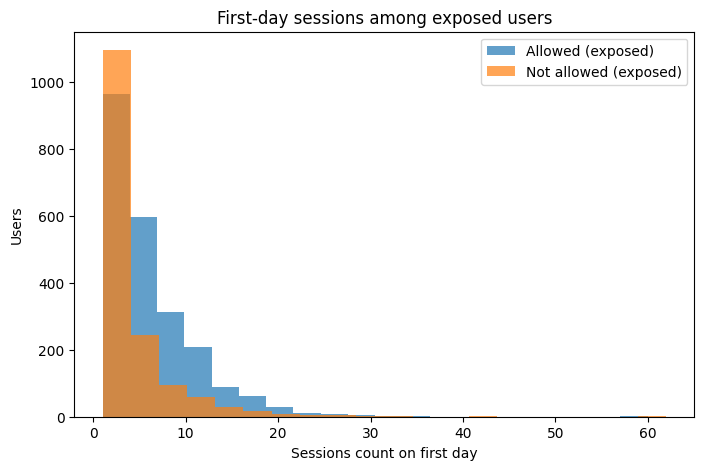

Mean sessions allowed (exposed): 5.7328976034858385
Mean sessions not allowed (exposed): 4.250639386189258
Median sessions allowed (exposed): 4.0
Median sessions not allowed (exposed): 3.0


In [32]:
exposed = user_base[user_base["notif_exposed"] == True]

allow_s_exp = exposed[exposed["allowed"] == 1]["sessions_count"]
noallow_s_exp = exposed[exposed["allowed"] == 0]["sessions_count"]

plt.figure(figsize=(8,5))
plt.hist(allow_s_exp, bins=20, alpha=0.7, label="Allowed (exposed)")
plt.hist(noallow_s_exp, bins=20, alpha=0.7, label="Not allowed (exposed)")
plt.xlabel("Sessions count on first day")
plt.ylabel("Users")
plt.title("First-day sessions among exposed users")
plt.legend()
plt.show()

print("Mean sessions allowed (exposed):", allow_s_exp.mean())
print("Mean sessions not allowed (exposed):", noallow_s_exp.mean())
print("Median sessions allowed (exposed):", allow_s_exp.median())
print("Median sessions not allowed (exposed):", noallow_s_exp.median())

## Battles played on first day

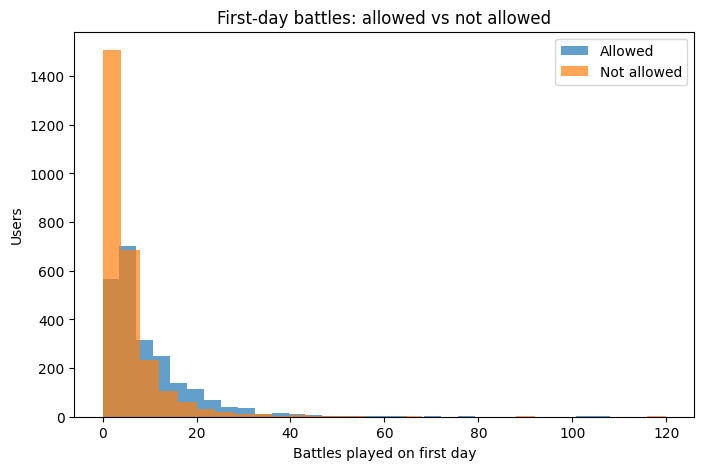

Mean battles allowed: 9.620915032679738
Mean battles not allowed: 5.052160953800298
Median battles allowed: 7.0
Median battles not allowed: 3.0


In [33]:
battles = user_base[["allowed", "battles_played"]]

allow_b = battles[battles["allowed"] == 1]["battles_played"]
noallow_b = battles[battles["allowed"] == 0]["battles_played"]

plt.figure(figsize=(8,5))
plt.hist(allow_b, bins=30, alpha=0.7, label="Allowed")
plt.hist(noallow_b, bins=30, alpha=0.7, label="Not allowed")
plt.xlabel("Battles played on first day")
plt.ylabel("Users")
plt.title("First-day battles: allowed vs not allowed")
plt.legend()
plt.show()

print("Mean battles allowed:", allow_b.mean())
print("Mean battles not allowed:", noallow_b.mean())
print("Median battles allowed:", allow_b.median())
print("Median battles not allowed:", noallow_b.median())

In [39]:
# Igraci koji dozvole notifikacije odigraju vise nego duplo borbi prvog dana
# allowed ima dugacak rep hardcore igraca
# not allowed se masovno gasi rano

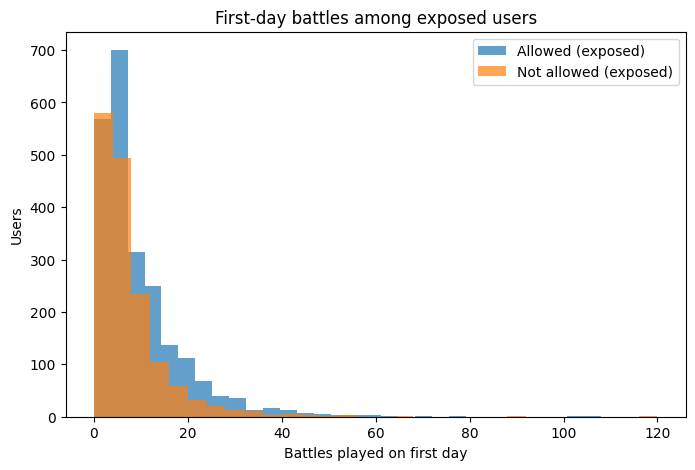

Mean battles allowed (exposed): 9.620915032679738
Mean battles not allowed (exposed): 7.101662404092072
Median battles allowed (exposed): 7.0
Median battles not allowed (exposed): 5.0


In [34]:
allow_b_exp = exposed[exposed["allowed"] == 1]["battles_played"]
noallow_b_exp = exposed[exposed["allowed"] == 0]["battles_played"]

plt.figure(figsize=(8,5))
plt.hist(allow_b_exp, bins=30, alpha=0.7, label="Allowed (exposed)")
plt.hist(noallow_b_exp, bins=30, alpha=0.7, label="Not allowed (exposed)")
plt.xlabel("Battles played on first day")
plt.ylabel("Users")
plt.title("First-day battles among exposed users")
plt.legend()
plt.show()

print("Mean battles allowed (exposed):", allow_b_exp.mean())
print("Mean battles not allowed (exposed):", noallow_b_exp.mean())
print("Median battles allowed (exposed):", allow_b_exp.median())
print("Median battles not allowed (exposed):", noallow_b_exp.median())

## Correlation

| Category            | Variable |
|--------------------|----------|
| Engagement         | playtime |
| Engagement         | sessions_count |
| Engagement         | battles_played |
| Decision           | allowed |
| Outcomes           | retained_d7 |
| Outcomes           | retained_d14 |
| Progression        | elo_rating |


In [58]:
corr_features = user_base[
    [
        "playtime",
        "sessions_count",
        "battles_played",
        "elo_rating",
        "allowed",
        "retained_d7",
        "retained_d14",
    ]
]

corr_matrix = corr_features.corr()

print("Correlation with allowed:")
print(corr_matrix["allowed"].sort_values(ascending=False))

print("\nCorrelation with retained_d7:")
print(corr_matrix["retained_d7"].sort_values(ascending=False))

Correlation with allowed:
allowed           1.000000
sessions_count    0.290371
retained_d7       0.283444
battles_played    0.267167
playtime          0.251448
retained_d14      0.241983
elo_rating        0.233855
Name: allowed, dtype: float64

Correlation with retained_d7:
retained_d7       1.000000
retained_d14      0.736831
sessions_count    0.717604
battles_played    0.595349
playtime          0.583975
elo_rating        0.572968
allowed           0.283444
Name: retained_d7, dtype: float64


In [52]:
order = [
    "playtime",
    "sessions_count",
    "battles_played",
    "allowed",
    "retained_d7",
    "retained_d14",
    "elo_rating",
]

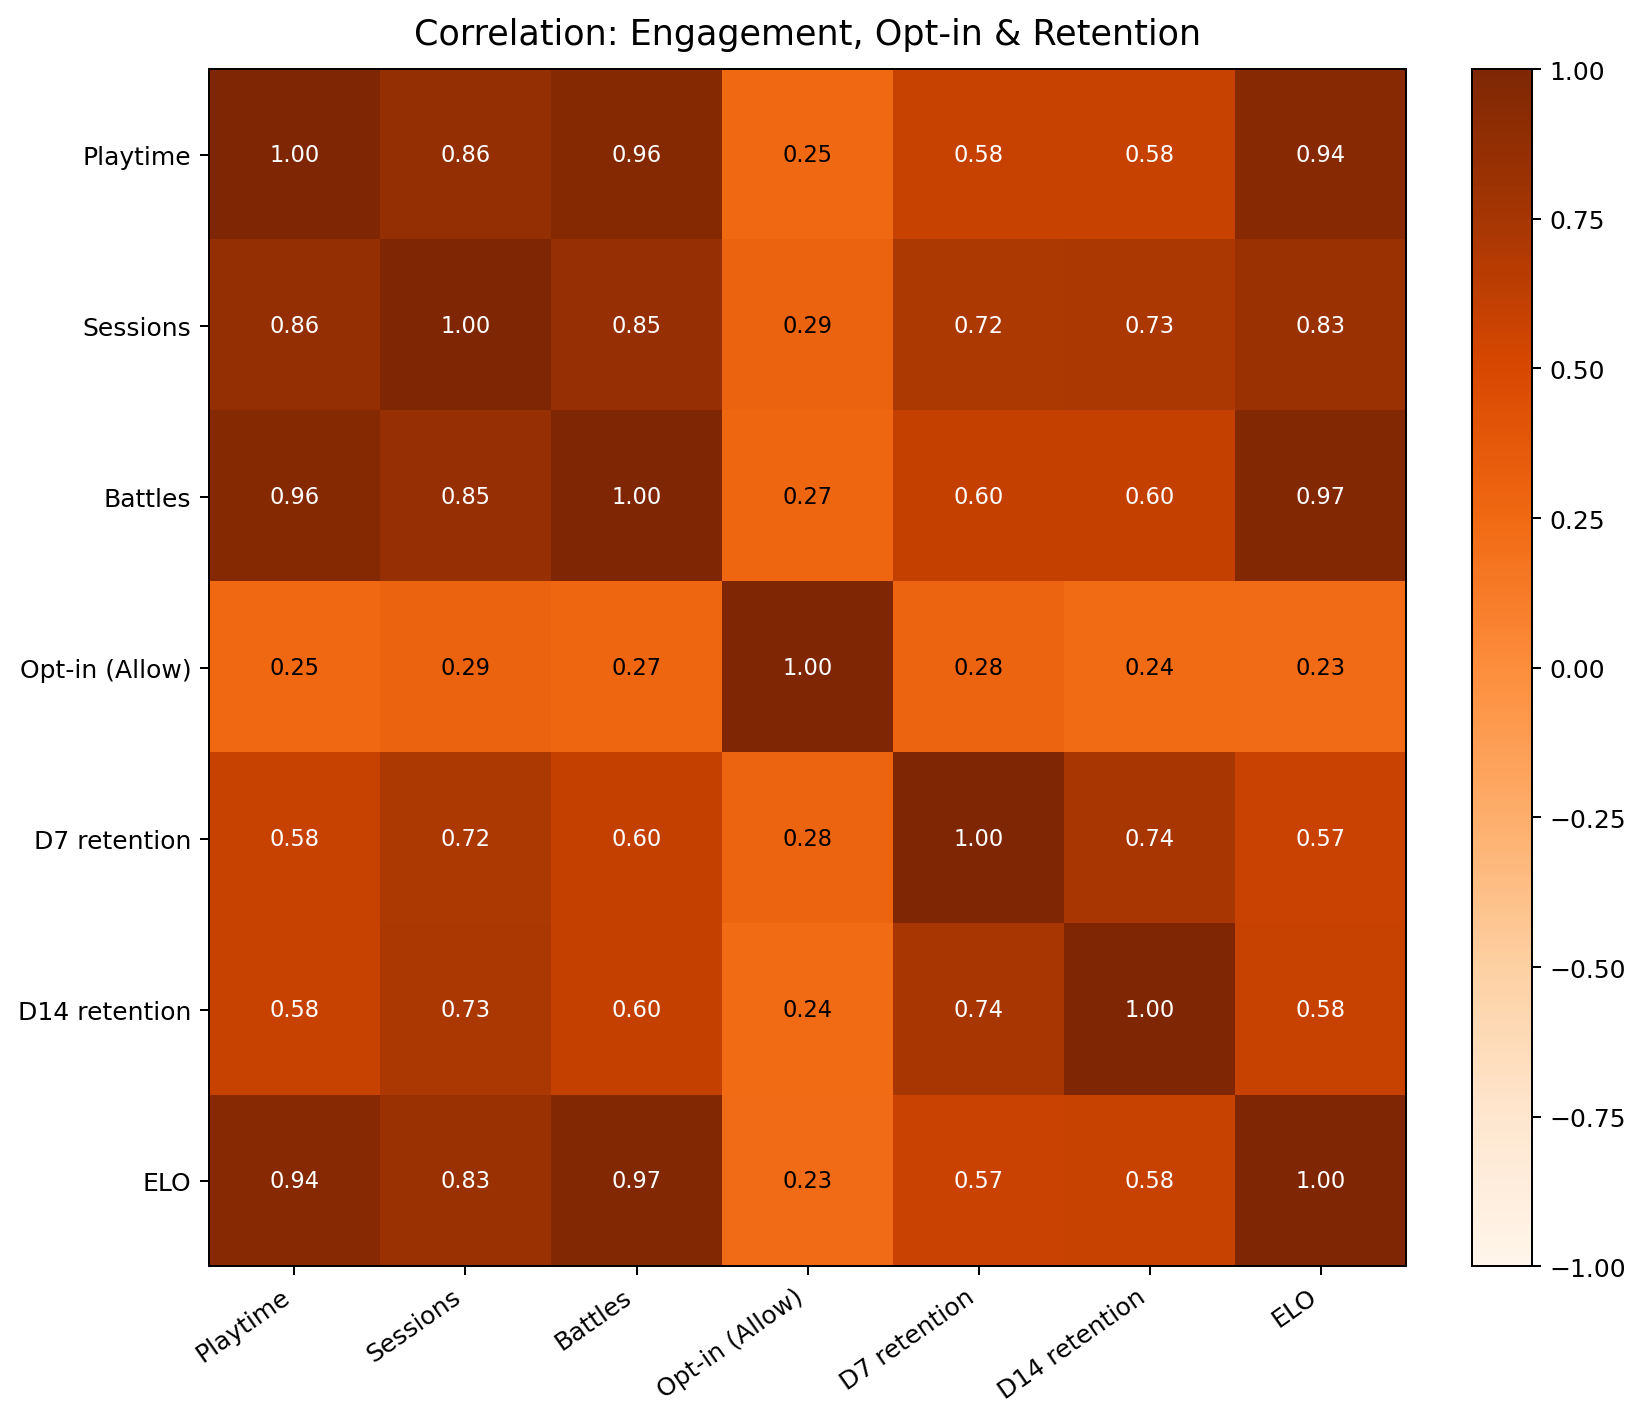

In [53]:
import numpy as np
import matplotlib.pyplot as plt

corr = corr_features.corr()

pretty = {
    "playtime": "Playtime",
    "sessions_count": "Sessions",
    "battles_played": "Battles",
    "elo_rating": "ELO",
    "allowed": "Opt-in (Allow)",
    "retained_d7": "D7 retention",
    "retained_d14": "D14 retention"
}

corr = corr_features[order].corr()
labels = [pretty.get(c, c) for c in corr.columns]
values = corr.values

plt.figure(figsize=(10, 8), dpi=180)
im = plt.imshow(values, cmap="Oranges", vmin=-1, vmax=1)

plt.xticks(range(len(labels)), labels, rotation=35, ha="right", fontsize=10)
plt.yticks(range(len(labels)), labels, fontsize=10)

for i in range(values.shape[0]):
    for j in range(values.shape[1]):
        v = values[i, j]
        txt_color = "white" if abs(v) >= 0.55 else "black"
        plt.text(j, i, f"{v:.2f}", ha="center", va="center",
                 fontsize=9, color=txt_color)

plt.title("Correlation: Engagement, Opt-in & Retention", fontsize=14, pad=10)
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.savefig("corr.png", bbox_inches="tight")
plt.show()


## Analiza korelacija izmedju engagementa, opt-ina i retentiona

Matrica korelacija pokazuje vrlo snaznu povezanost izmedju ranog ponasanja igraca i njihove dugorocne aktivnosti u igri.

Pre svega, metrike angazovanosti prvog dana (`playtime`, `sessions_count`, `battles_played`, `elo_rating`) su medjusobno izuzetno visoko korelisane. Na primer, `playtime` i `battles_played` imaju korelaciju od 0.96, dok je veza izmedju `battles_played` i `elo_rating` cak 0.97. Ovo ukazuje da svi ovi feature-i prakticno mere isti latentni koncept, ranu angazovanost i investiranost igraca u igru.

Zatim se vidi da su sve engagement metrike snazno povezane sa retentionom:

- `sessions_count` ima korelaciju od oko **0.72** sa D7 i D14 retentionom  
- `battles_played` i `playtime` su oko **0.58–0.60**  
- `elo_rating` je takodje oko **0.57–0.58**

Drugim recima, sto je igrac aktivniji na samom pocetku, znacajno je veca verovatnoca da ce ostati u igri i nakon nedelju ili dve dana. Ovo potvrdjuje da je **rani engagement glavni prediktor dugorocnog zadrzavanja igraca**.

Korelacija izmedju dozvole za notifikacije (`allowed`) i engagementa je pozitivna, ali znatno slabija u odnosu na retention:

- `sessions_count` ~ **0.29**  
- `battles_played` ~ **0.27**  
- `playtime` ~ **0.25**  
- `elo_rating` ~ **0.23**

To znaci da aktivniji igraci cesce prihvataju notifikacije, ali ta veza nije ekstremno jaka. Opt-in odluka je povezana sa ponasanjem, ali nije iskljucivo njime odredjena.

Slicno vazi i za vezu izmedju `allowed` i retentiona, gde su korelacije oko **0.24–0.28**. Igraci koji prihvate notifikacije u proseku imaju veci retention, ali je ocigledno da je engagement mnogo jaci faktor od same dozvole za notifikacije.

Vazan dodatni uvid je veoma jaka korelacija izmedju D7 i D14 retentiona (**0.74**), sto pokazuje da igraci koji prezive prvu nedelju imaju znatno vecu sansu da ostanu aktivni i nakon dve nedelje. Prvi dani igre su kljucni period za zadrzavanje korisnika.

---

## Glavni zakljucci

- **Rani engagement je najvazniji pokretac i opt-ina i retentiona.**  
  Metrike kao sto su broj sesija, odigrane borbe i ukupno vreme igranja gotovo direktno predvidjaju dugorocno ponasanje igraca.

- **Prihvatanje notifikacija je povezano sa vecom aktivnoscu i boljim retentionom**, ali znatno slabije nego sto je to slucaj sa samim engagementom.  
  Notifikacije su vise signal angazovanosti nego njen uzrok.

- **Retention se formira veoma rano u zivotnom ciklusu igraca.**  
  Prvih nekoliko sesija i ponasanje prvog dana nose najvecu kolicinu informacija o buducem zadrzavanju.

Ovi rezultati sugerisu da optimizacija ranog iskustva i podsticanje engagementa ima veci dugorocni uticaj nego sama strategija slanja notifikacija, dok notifikacije mogu sluziti kao dodatni alat za zadrzavanje vec angazovanih igraca.
